In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [26]:
transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = datasets.FashionMNIST(root='./data', download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [27]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU()
        )
        self.mu = nn.Linear(400, 20)
        self.logvar = nn.Linear(400, 20)
        self.decoder = nn.Sequential(
            nn.Linear(20, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.encoder(x)
        mu, logvar = self.mu(h), self.logvar(h)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [28]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

In [29]:
vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=0.001)

In [30]:
for epoch in range(10):
    total_loss = 0
    for x, _ in train_dataloader:
        x = x.view(-1, 28*28)
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(x)
        loss = loss_function(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_dataloader.dataset):.4f}")

Epoch 1, Loss: 274.3479
Epoch 2, Loss: 251.1370
Epoch 3, Loss: 247.1445
Epoch 4, Loss: 245.3928
Epoch 5, Loss: 244.2594
Epoch 6, Loss: 243.4269
Epoch 7, Loss: 242.9141
Epoch 8, Loss: 242.4118
Epoch 9, Loss: 242.0019
Epoch 10, Loss: 241.6962


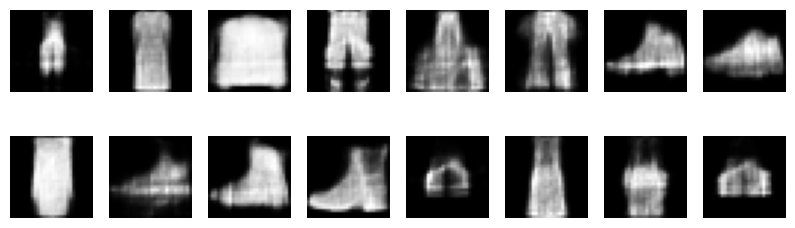

In [31]:
with torch.no_grad():
    z = torch.randn(16, 20)  # Сэмплируем случайные точки из латентного пространства
    samples = vae.decoder(z).view(-1, 28, 28)
    
    fig, axes = plt.subplots(2, 8, figsize=(10, 3))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i], cmap='gray')
        ax.axis('off')
    plt.show()
